In [2]:
#setup
data_dir='../../Data/Weather'
file_index= 'SSSBSBBS'#'BBBSBBBB'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [3]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1539.8|    38.6|-119.4833|       SNWD|USC00048969|    20|[00 00 00 00 00 0...|1954.0|SSSBSBBS|
|   1410.9| 38.8667|-117.9167|       SNWD|USC00262948|    36|[00 7E 00 7E 00 7...|2012.0|SSSBSBBS|
|    723.0| 38.3833|-120.5667|       SNWD|USC00049583|     1|[00 00 60 56 C0 5...|1950.0|SSSBSBBS|
|    723.0| 38.3833|-120.5667|       SNWD|USC00049583|     1|[00 00 00 00 00 0...|1951.0|SSSBSBBS|
|    723.0| 38.3833|-120.5667|       SNWD|USC00049583|     4|[00 00 00 00 00 0...|1952.0|SSSBSBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

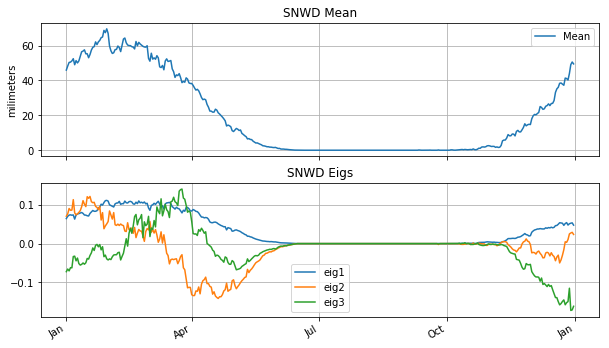

In [7]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
axes[0].set_ylabel('milimeters')
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [8]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

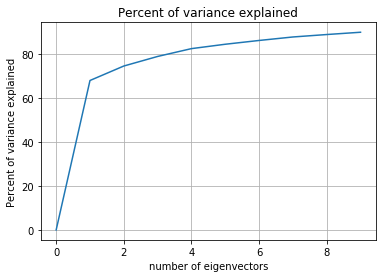

In [9]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [10]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [11]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1464
after filter 330


In [12]:
# Sort entries by increasing values of ers_3
df3=df3.sort(df3.res_3,ascending=True)

In [42]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
#             _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
#                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
#             print i,j,_title,axes[i,j]
            _title='c3=%3.2f,r3=%3.2f'%(row['coeff_3'],row['res_3'])
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title = _title,interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [40]:
#values are ascending
df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_2)
rows=df4.take(12)
df4.select('coeff_2','res_2').show(4)

+------------------+-------------------+
|           coeff_2|              res_2|
+------------------+-------------------+
|-5238.305667275657|  0.149602912379729|
|-5018.069523170186|0.12108374913481737|
|-4806.644028305773|0.07909749220095065|
|-4473.351305608826| 0.0743108509710905|
+------------------+-------------------+
only showing top 4 rows



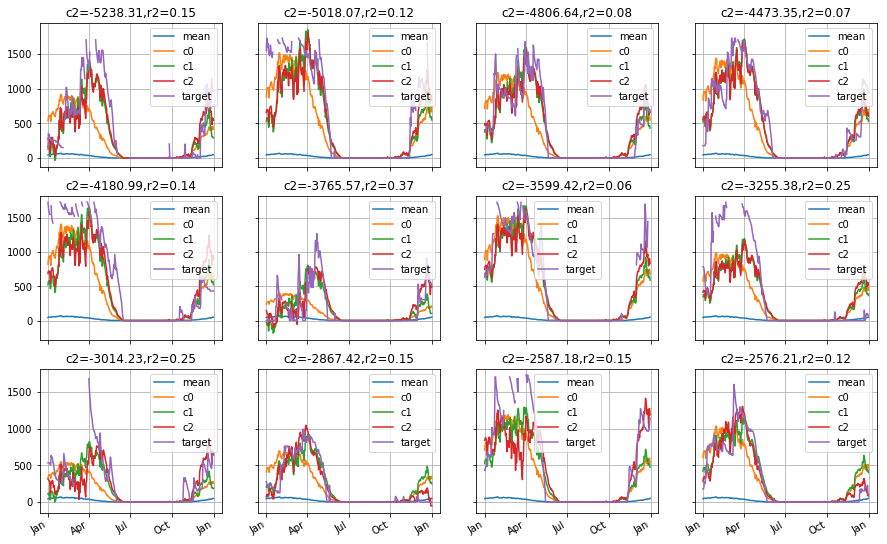

In [41]:
plot_recon_grid(rows)

In [18]:
df3.sort?

In [15]:
#values are descending
df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
rows=df5.take(12)
df5.select('coeff_2','res_2').show(4)

+------------------+-------------------+
|           coeff_2|              res_2|
+------------------+-------------------+
|4561.0161166226535|0.05316628297850684|
| 3604.182341654651|0.13791852384490955|
|3469.5797756341576|0.03518361990692437|
|3378.9860511385987|0.09053591125188934|
+------------------+-------------------+
only showing top 4 rows



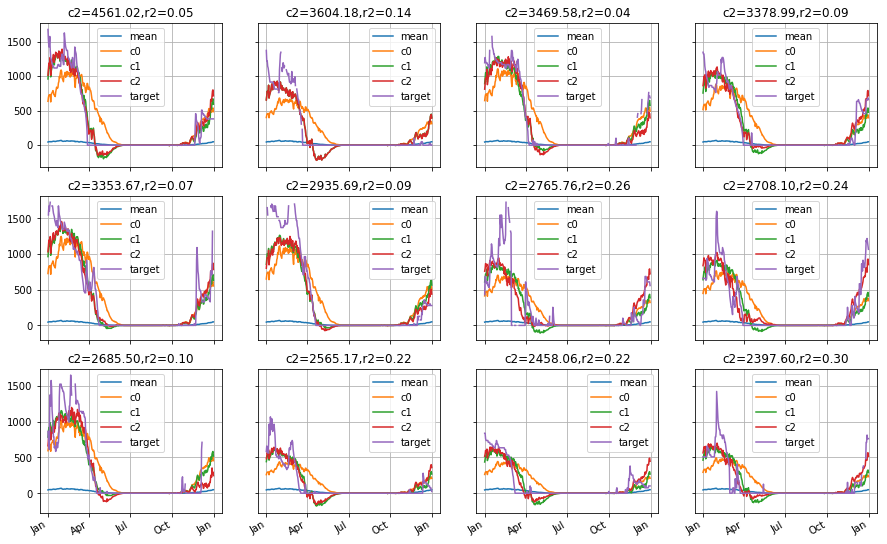

In [39]:
plot_recon_grid(rows)

In [18]:
#values are ascending
df_c1_a=df3.filter(df3.res_1<0.4).sort(df3.coeff_1)
rows_c1_a=df_c1_a.take(12)
df_c1_a.select('coeff_1','res_1').show(4)


+------------------+------------------+
|           coeff_1|             res_1|
+------------------+------------------+
| 2295.270458051066| 0.373668647800711|
|2851.1711489381482|0.3997853828707583|
|3447.5599768050383| 0.264174072052219|
|3749.4234737190745|0.3443133602097574|
+------------------+------------------+
only showing top 4 rows



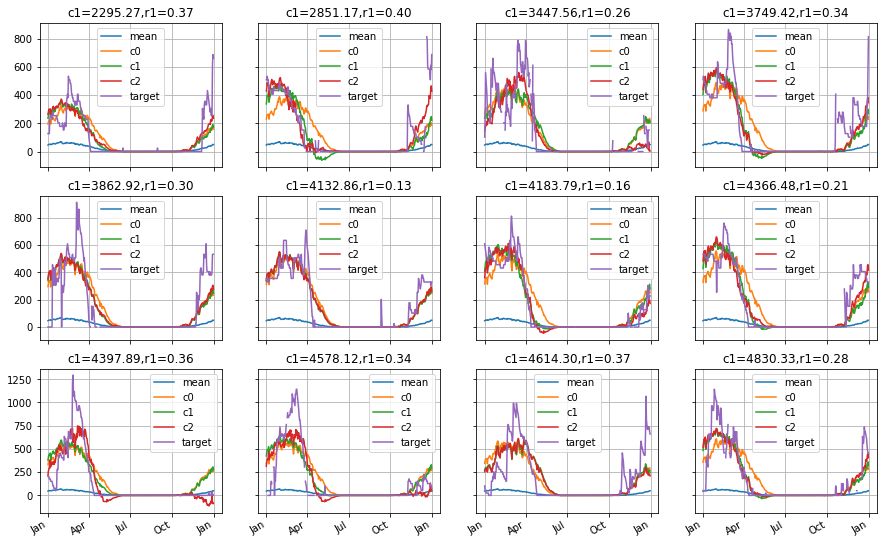

In [35]:

plot_recon_grid(rows_c1_a)  # for coeff_1 ASCENDING (most negative)

In [23]:
#values are descending
df_c1_d=df3.filter(df3.res_1<0.4).sort(df3.coeff_1,ascending=False)
rows_c1_d=df_c1_d.take(12)
df_c1_d.select('coeff_1','res_1').show(4)


+------------------+-------------------+
|           coeff_1|              res_1|
+------------------+-------------------+
|13076.705011155133|0.10083434297470502|
|12934.805238149642|0.15449953351754048|
| 12806.44750509029|0.07424592157516342|
|12228.827571180394|0.18886211303327813|
+------------------+-------------------+
only showing top 4 rows



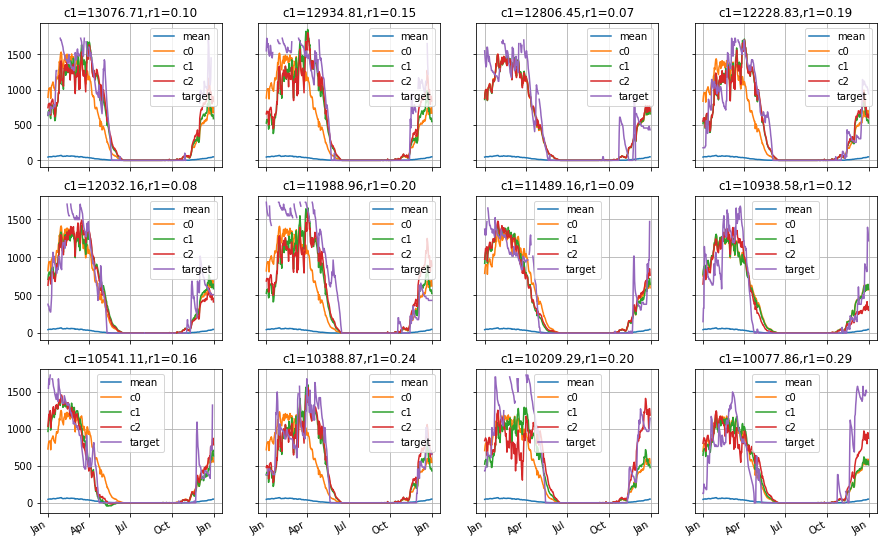

In [36]:
plot_recon_grid(rows_c1_d) # for coeff_1 DESC (most postitive)

In [24]:
#values are ascending
df_c3_a=df3.filter(df3.res_3<0.4).sort(df3.coeff_3)
rows_c3_a=df_c3_a.take(12)
df_c3_a.select('coeff_3','res_3').show(4)



+-------------------+-------------------+
|            coeff_3|              res_3|
+-------------------+-------------------+
| -4372.891499530628| 0.1458123305553984|
|-3562.9981990881556|0.25045381268410427|
| -3180.717289937388|0.35402993179684983|
| -2821.067775026614| 0.2205363575234621|
+-------------------+-------------------+
only showing top 4 rows



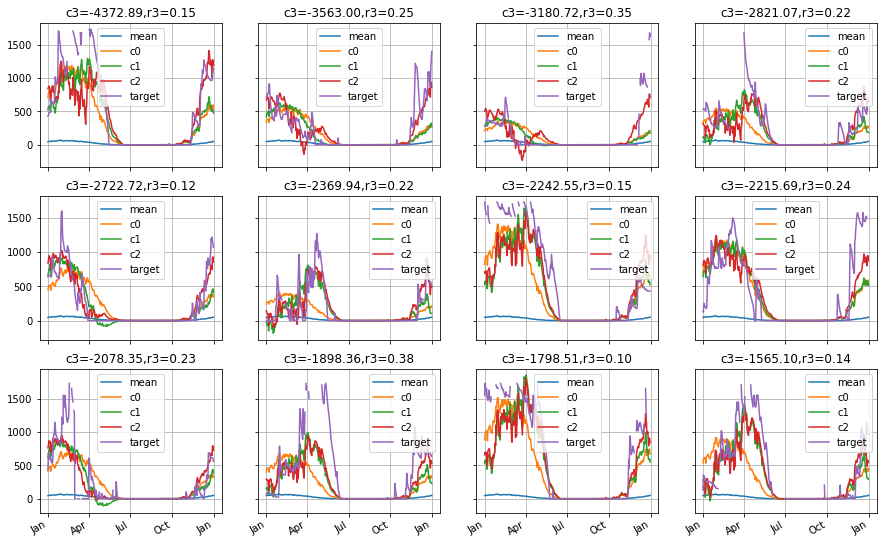

In [43]:
plot_recon_grid(rows_c3_a) # for coeff_a ASC (most negative)

In [25]:
#values are descending
df_c3_d=df3.filter(df3.res_3<0.4).sort(df3.coeff_3,ascending=False)
rows_c3_d=df_c3_d.take(12)
df_c3_d.select('coeff_3','res_3').show(4)



+------------------+--------------------+
|           coeff_3|               res_3|
+------------------+--------------------+
| 4418.212987439299|  0.1240934812194983|
| 4330.184297308271| 0.05448009854297796|
| 3975.668171604316| 0.07306212666108892|
|3572.6876293709515|0.056796420722464415|
+------------------+--------------------+
only showing top 4 rows



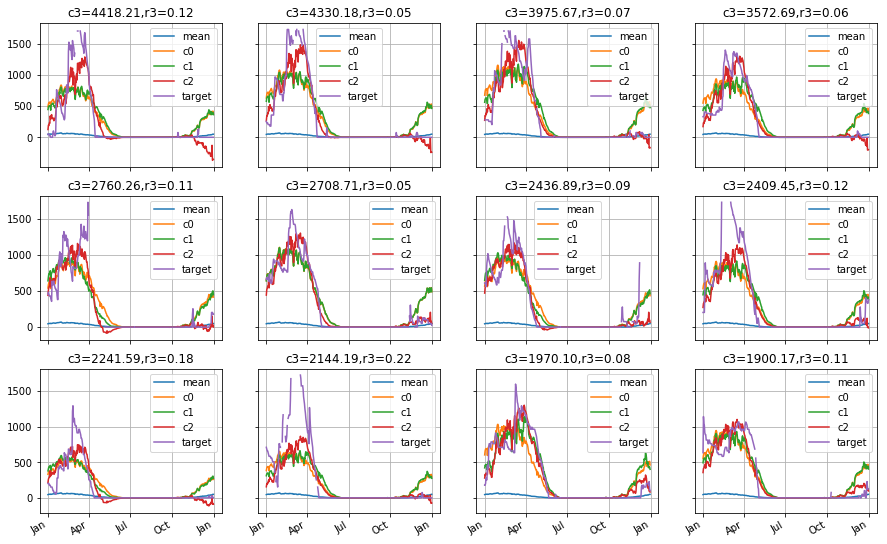

In [44]:
plot_recon_grid(rows_c3_d) # for coeff_3 DESC (most postitive)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.906513765458
residual normalized norm  after mean + top eigs: [ 0.24247131  0.05316628  0.04804022]


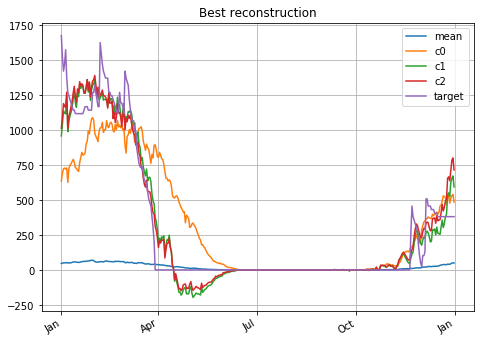

In [21]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [22]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals) < len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

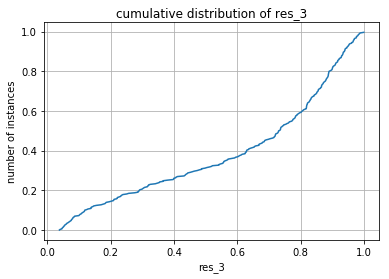

In [26]:
plot_CDF('res_3')
#plot_CDF('res_2')

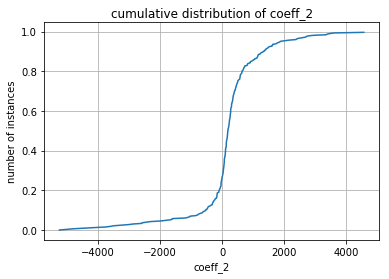

In [27]:
plot_CDF('coeff_2')

In [ ]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [ ]:
!du -sh $data_dir/*.parquet

In [45]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

ValueError: too many values to unpack

In [28]:
L=len(Stations)
Pvals=np.zeros([L,L])
Length=np.zeros([L,L])
P_norm=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j: 
            P_norm[i,j]=-0.4
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
        if Length[i,j]<200:
            P_norm[i,j]=np.nan

NameError: name 'Stations' is not defined

In [29]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

NameError: name 'All' is not defined

In [27]:
def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~isnan(X)
    m=sum(G)
    XG=X[G]>0
    YG=Y[G]>0
    n1=sum(XG)
    n2=sum(YG)
    l=sum(XG*YG)
    logprob=LogProb(m,l,n1,n2)
    # print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,logprob)
    return logprob,m
# log,M = computeLogProb(X,Y)
# print log, M
# print exp(log)